In [14]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().resolve().parent.parent))

In [15]:
# running experiments
from experiments.run_experiment import (
    TrainingConfig,
    EvaluateConfig,
)
from experiments.run_sweep import run_sweep, plot_sweep_training, plot_sweep_evaluation

# environments
from environments.fronzenlake import FrozenLakeConfig, get_frozenlake_env
from environments.cliffwalking import CliffWalkingConfig, get_cliffwalking_env

# SARSA Variant agent
from agents.sarsa_td0_variant import (
    SarsaTD0VariantAgent,
    SarsaTD0VariantConfig,
)

# metrics for training
from metrics.learning_mertrics import total_reward_per_episode, episode_won
from metrics.frustration_metrics import (
    total_td_error_per_episode,
    frustration_rate_per_episode,
    tail_frustration_per_episode,
    cvar_tail_frustration_per_episode,
)

# external libraries
import numpy as np

## Environments

In [16]:
# env_config = FrozenLakeConfig(map_name="4x4", is_slippery=False)
env_config = FrozenLakeConfig(
    map_name="4x4",
    is_slippery=True,
    reward_schedule=(1.0, -1.0, -0.1),
)

## Agents

In [17]:
## Agents
# sarsa_td0 agent
agent_factory = SarsaTD0VariantAgent

sarsa_td0_config = SarsaTD0VariantConfig(
    alpha_positive=0.2,
    alpha_negative=0.2,
    gamma=0.99,
    epsilon=0.3,
    reward_metrics={
        "total_reward_per_episode": total_reward_per_episode,
        "episode_won": episode_won,
    },
    td_error_metrics={
        "total_td_error_per_episode": total_td_error_per_episode,
        "frustration_rate_per_episode": frustration_rate_per_episode,
        "tail_frustration_per_episode": lambda td: tail_frustration_per_episode(
            td, percentile=0.90
        ),
        "cvar_tail_frustration_per_episode": lambda td: cvar_tail_frustration_per_episode(
            td, percentile=0.90
        ),
    },
)

## Sweep configuration

In [18]:
base_train = TrainingConfig(
    name="sarsa_frozenlake",
    num_train_episodes=12000,
    env_kwargs={"config": env_config},
    agent_kwargs={"config": sarsa_td0_config},
)

base_eval = EvaluateConfig(
    name="sarsa_frozenlake",
    num_eval_episodes=2000,
    env_kwargs={"config": env_config},
)

In [19]:
# different q_tables
env = get_frozenlake_env(env_config)
num_states = env.observation_space.n
num_actions = env.action_space.n
q0 = np.ones((num_states, num_actions), dtype=np.float64)

In [20]:
sweep = {
    "agent_kwargs": [
        {"alpha_positive": ap, "alpha_negative": an, "seed": 1, "initial_q_table": q0, "initial_q_table_label": f"test"}
        for ap, an in [
            (0.05, 0.05),
            (0.1, 0.1),
            (0.2, 0.2),
            (0.1, 0.05),
            (0.2, 0.05),
            (0.3, 0.1),
            (0.05, 0.1),
        ]
    ],
}

## Results

In [21]:
results = run_sweep(
    base_training=base_train,
    base_evaluation=base_eval,
    sweep=sweep,
    env_factory=get_frozenlake_env,
    agent_factory=agent_factory,
)


TypeError: SarsaTD0VariantConfig.__init__() got an unexpected keyword argument 'initial_q_table_label'

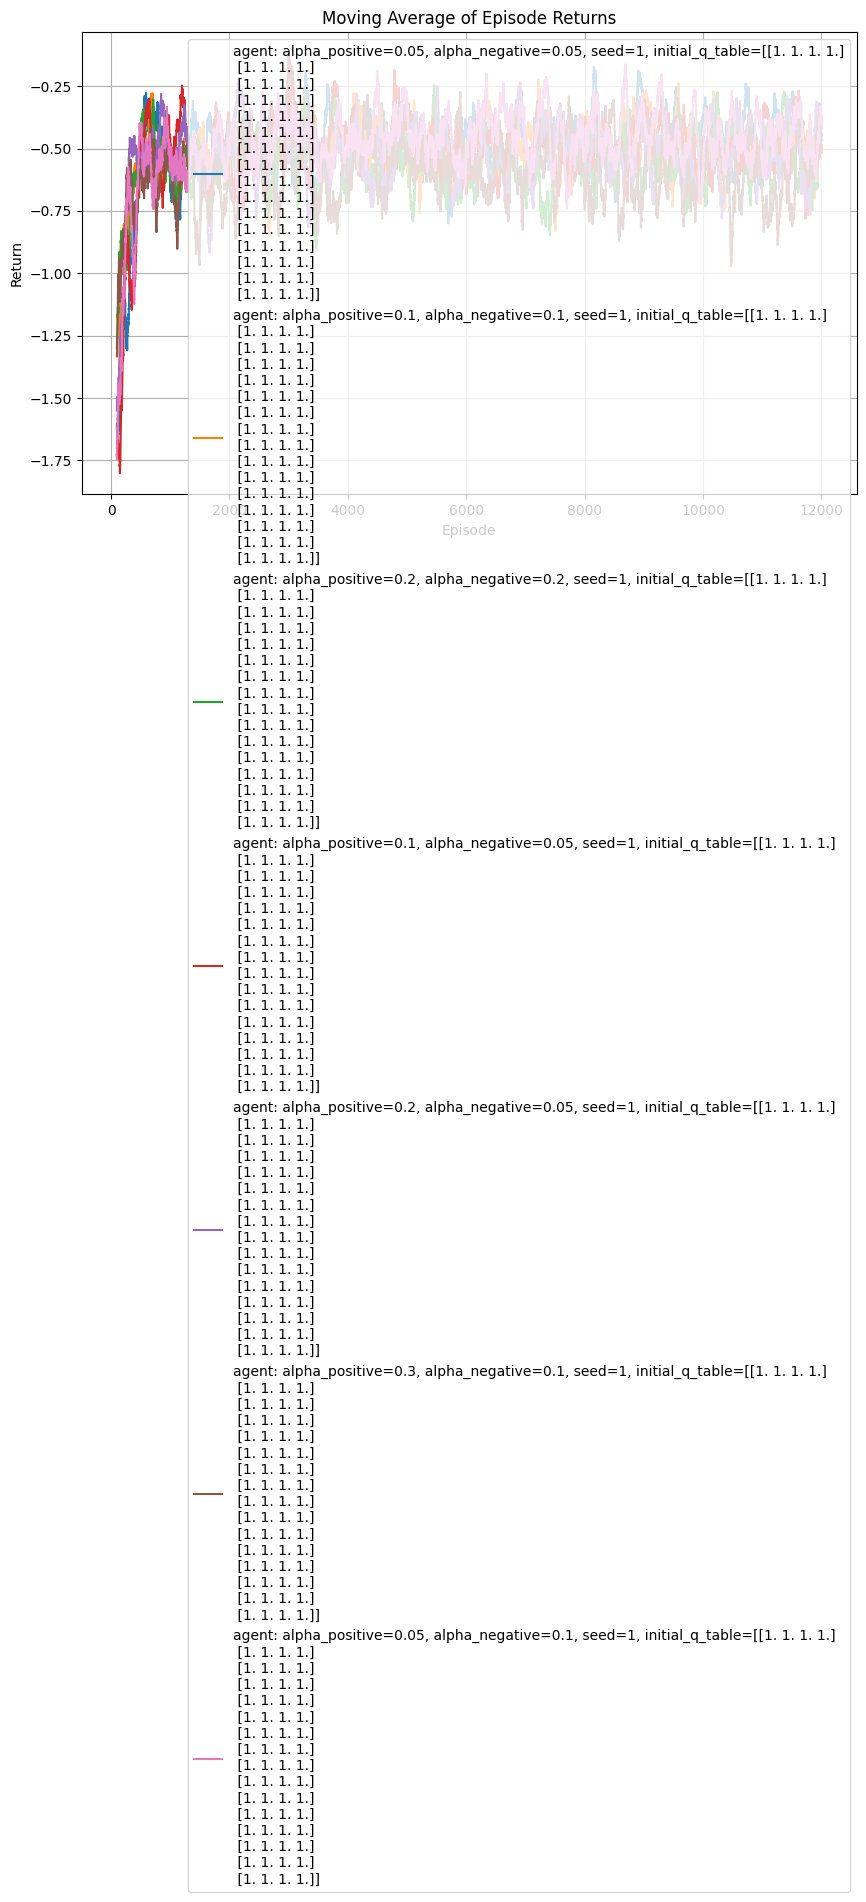

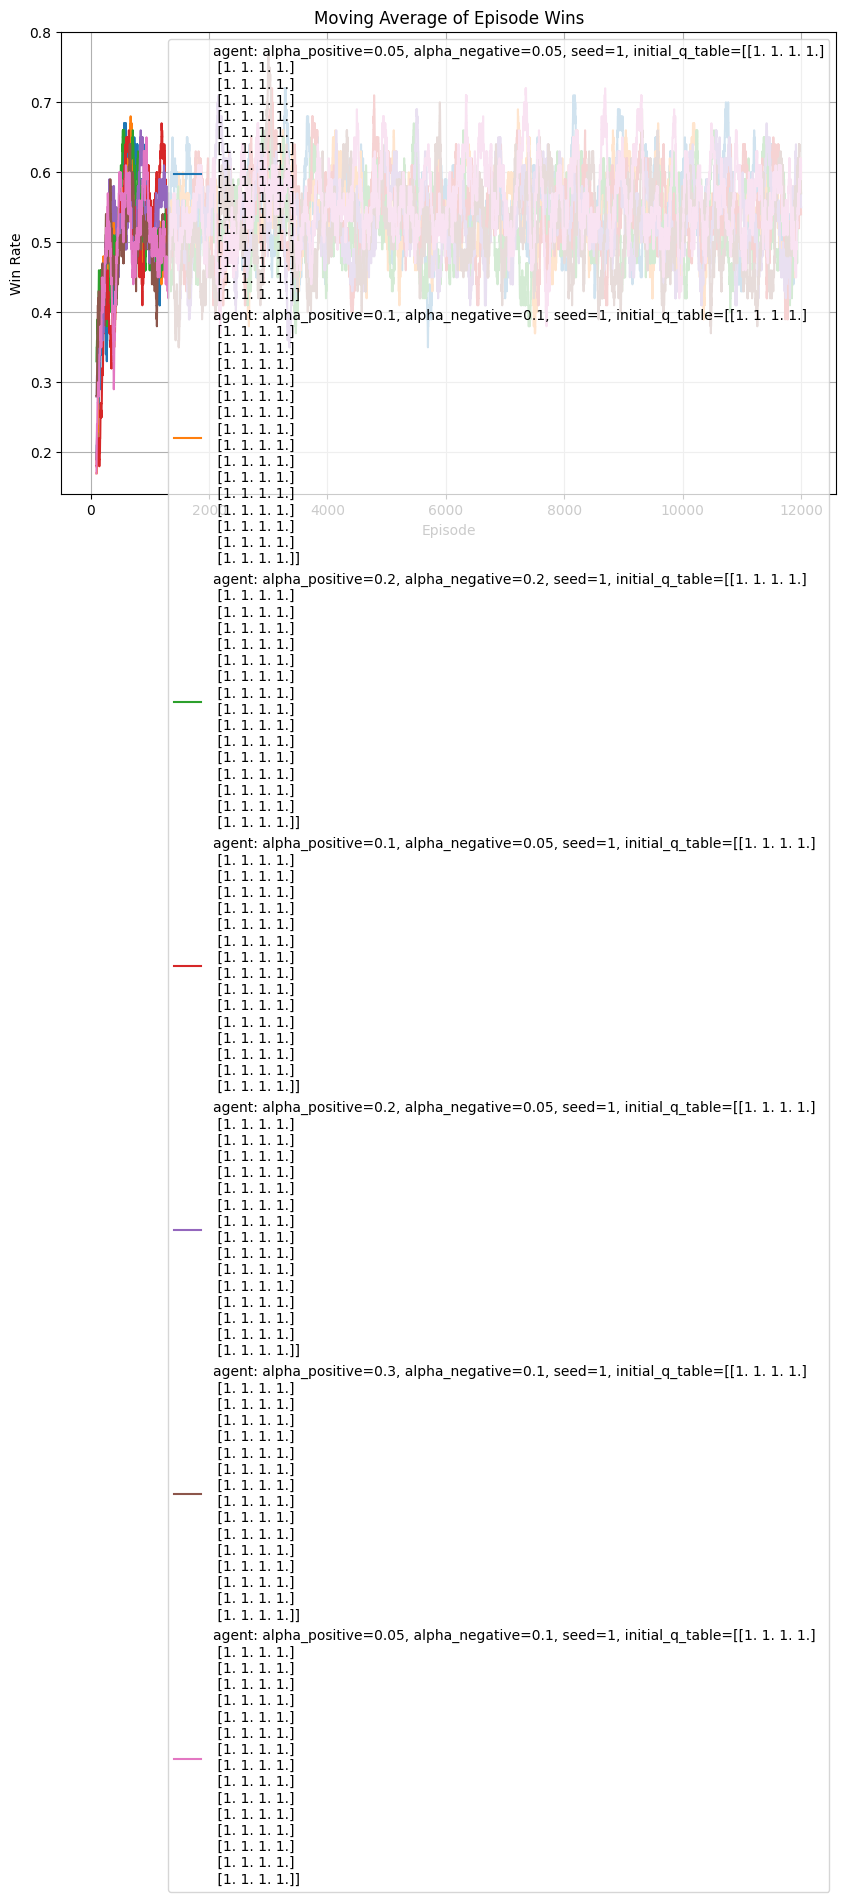

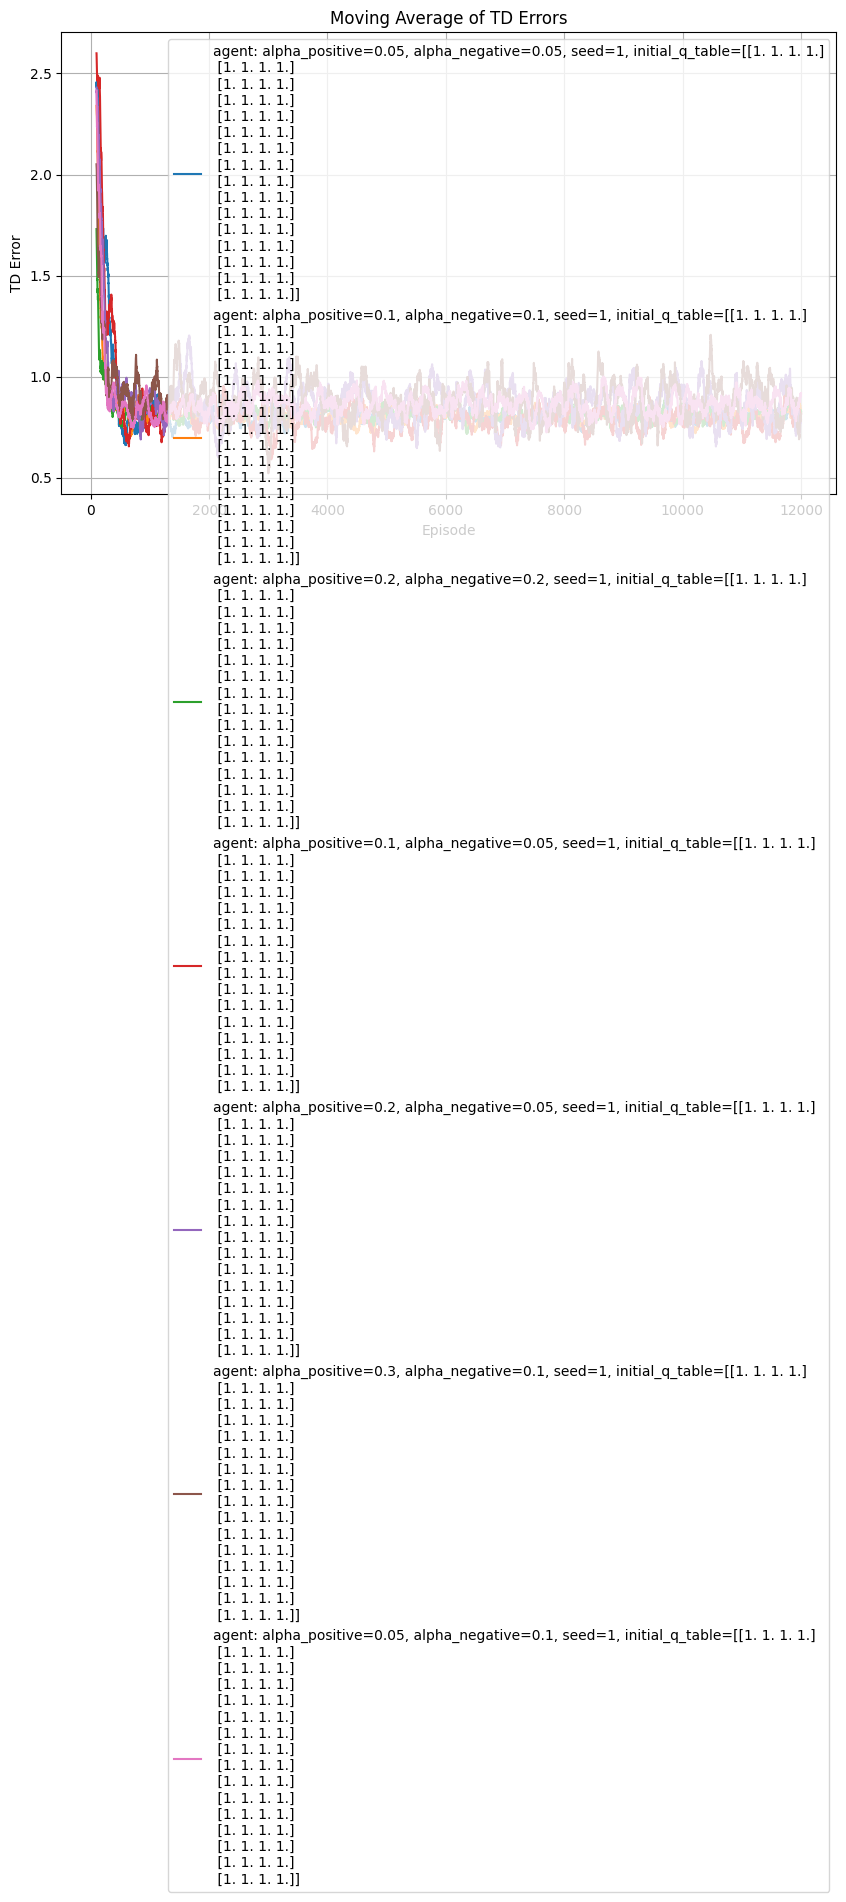

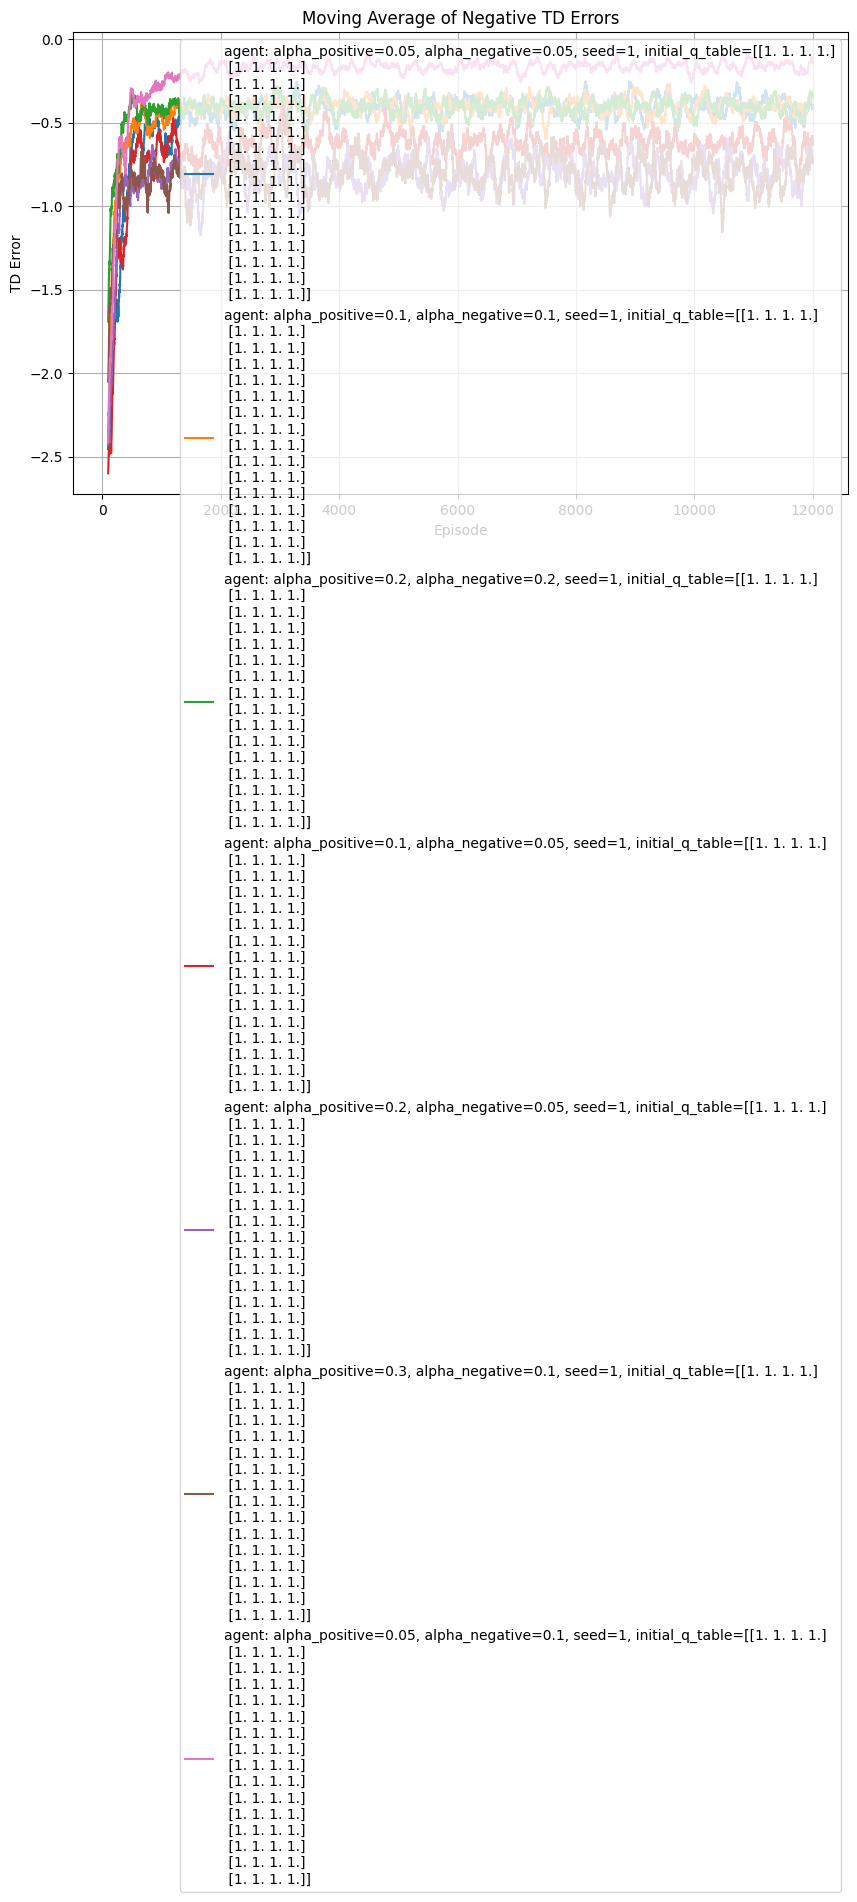

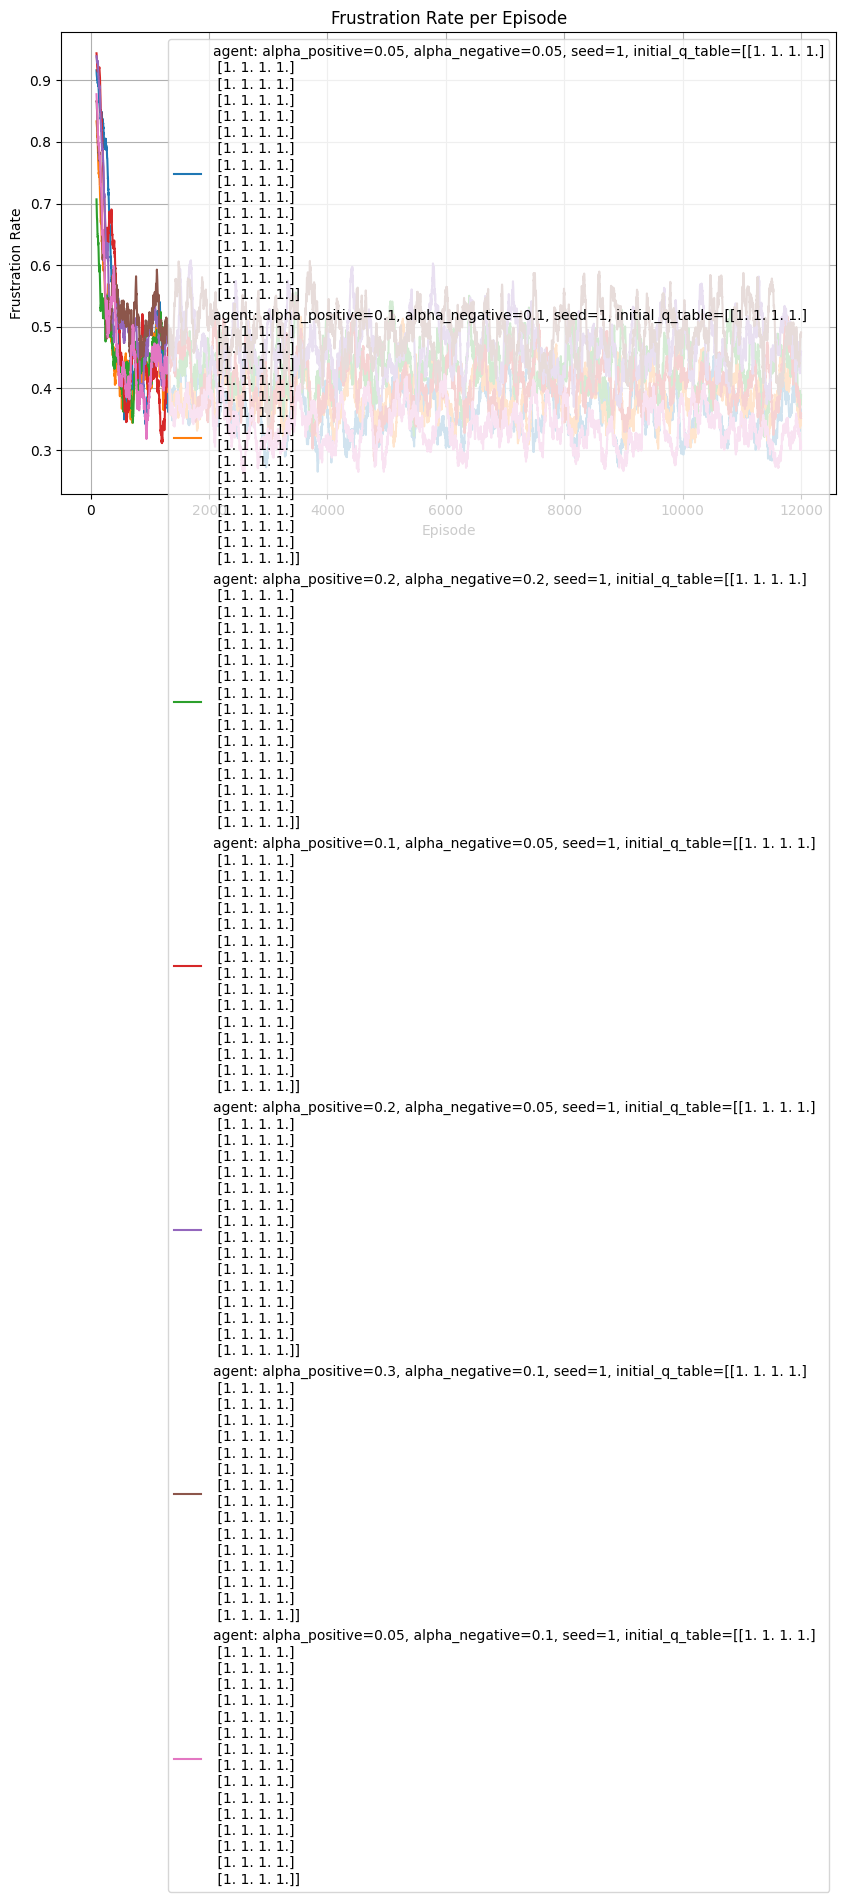

In [13]:
plot_sweep_training(results, window_size=100)

In [ ]:
plot_sweep_evaluation(results)